<a href="https://colab.research.google.com/github/sungueve/Yvonne-/blob/main/timeseries_1513.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#installing darts -  a library for time series
!pip install darts --quiet


import darts
print(f"Darts version: {darts.__version__}")


Darts version: 0.27.2


In [ ]:
#using darts
from darts import TimeSeries

In [ ]:
import pandas as pd

df = pd.read_csv("/content/1513_new.csv", header=1, names=['year_month', 'total_paid'])
print(df.shape)
df.head()

(44, 2)


,year_month,total_paid
0,2016-05,25239.59
1,2016-06,25646.22
2,2016-07,20545.25
3,2016-08,18381.85
4,2016-09,18580.50


In [ ]:
df.isnull

<bound method DataFrame.isnull of    year_month  total_paid
0     2016-05    25239.59
1     2016-06    25646.22
2     2016-07    20545.25
3     2016-08    18381.85
4     2016-09    18580.50
5     2016-10    29634.94
6     2016-11    27264.99
7     2016-12    28721.61
8     2017-01    28627.72
9     2017-02    26792.00
10    2017-03    29609.79
11    2017-04    24464.91
12    2017-05    24551.90
13    2017-06    19273.20
14    2017-07    22225.75
15    2017-08    21298.35
16    2017-09    24709.96
17    2017-10    24993.38
18    2017-11    24840.28
19    2017-12    25591.35
20    2018-01    22962.33
21    2018-02    23198.62
22    2018-03    26092.06
23    2018-04    19518.04
24    2018-05    16143.07
25    2018-06    16589.43
26    2018-07    13938.72
27    2018-08    12725.24
28    2018-09    16279.13
29    2018-10    17954.84
30    2018-11    18862.26
31    2018-12    23088.79
32    2019-01    26982.24
33    2019-02    20130.35
34    2019-03    25064.12
35    2019-04    21659.36
36  

In [ ]:
df.tail()

,year_month,total_paid
39,2019-08,14063.58
40,2019-09,19260.67
41,2019-10,25867.95
42,2019-11,22415.25
43,2019-12,19421.61


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44 entries, 0 to 43
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   year_month  44 non-null     object 
 1   total_paid  44 non-null     float64
dtypes: float64(1), object(1)
memory usage: 832.0+ bytes


In [ ]:
# Convert 'month_year' column to datetime format
df['year_month'] = pd.to_datetime(df['year_month'])

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44 entries, 0 to 43
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   year_month  44 non-null     datetime64[ns]
 1   total_paid  44 non-null     float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 832.0 bytes


<Axes: xlabel='year_month'>

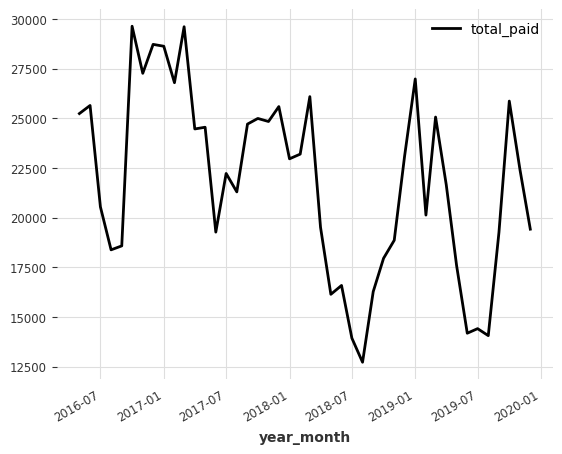

In [ ]:
#to create a TimeSeries object, you need to specify the dataframe that you're using,
#and which is the temporal column(months) and which is the column to predict (total_value_paid)
# plot that shows how revenue varies across time

from darts import TimeSeries
series = TimeSeries.from_dataframe(df, 'year_month', 'total_paid')
series.plot()

In [ ]:
#missing values
#it's important to fill missing values in the column whose values you're trying to predict (in your case the revenue column)
from darts.utils.missing_values import fill_missing_values
series = fill_missing_values(series)

In [ ]:
#if you observe an exponential trend, do this
import numpy as np
logged = (series).map(lambda x: np.log(x))

<Axes: xlabel='year_month', ylabel='total_paid'>

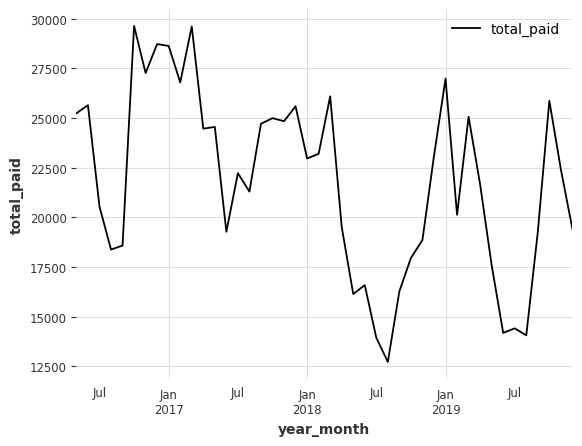

In [ ]:
# Set 'month_year' column as the index
df = df.set_index('year_month')

# Plot the time series
df.plot(y='total_paid', xlabel='year_month', ylabel='total_paid')


In [ ]:
#scale the data
from darts.dataprocessing.transformers.scaler import Scaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
ts_transformer = Scaler(scaler)
scaled_ts = ts_transformer.fit_transform(logged)

<Axes: xlabel='year_month'>

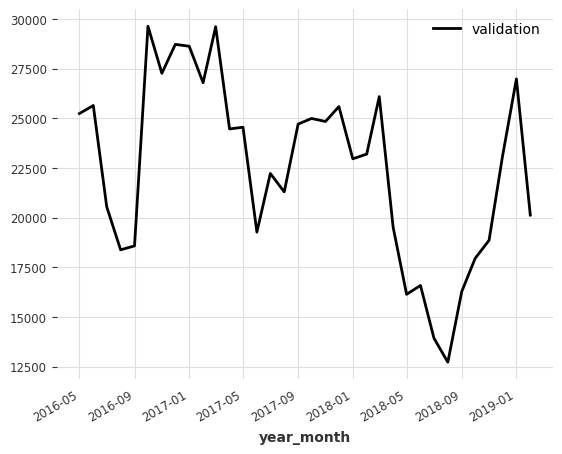

In [ ]:
#train test split
train, test = (series).split_before(0.8)
train.plot(label="validation")

<Axes: xlabel='year_month'>

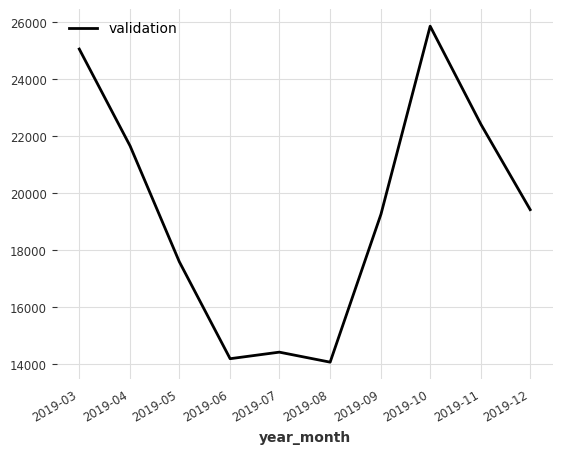

In [ ]:
#train test split
train, test = (series).split_before(0.8)
test.plot(label="validation")

In [ ]:
#1. model option: ExponentialSmoothing
#it assigns larger weights to more recent observations while assigning exponentially
#decreasing weights as the observations get increasingly distant.

In [ ]:
from darts.models import ExponentialSmoothing

# initialize and fit an Exponential Smoothing model
model = ExponentialSmoothing()
model.fit(train)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



ExponentialSmoothing(trend=ModelMode.ADDITIVE, damped=False, seasonal=SeasonalityMode.ADDITIVE, seasonal_periods=None, random_state=0, kwargs=None)

In [ ]:
# generate predictions (for the test set)
exp_forecast = model.predict(len(test))

<Axes: xlabel='year_month'>

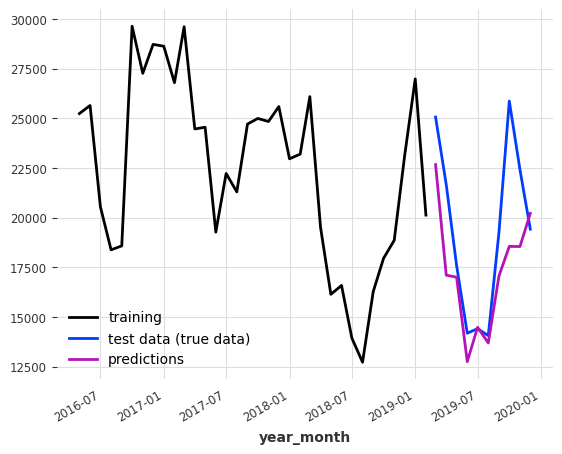

In [ ]:
#plot the training data, the test data and your predictions
train.plot(label="training")
test.plot(label="test data (true data)")
exp_forecast.plot(label = "predictions")

In [ ]:
#evaluate how accurate your generated predictions are (compared to the true data in Test set)
from darts.metrics import mape
accuracy = mape(test, exp_forecast)
print(f"Mean Absolute Percentage Error: {accuracy}")

Mean Absolute Percentage Error: 10.812569235845737


In [ ]:
#2. multiple models
from darts.models import AutoARIMA, Prophet, TBATS

In [ ]:
#generate predictions using each of the additional models - AutoArima, Prophet and TBATS
#calculate the MAPE score for each of them
#interpret these MAPE scores by comparing them with the MAPE score that the Exponential Smoothing model gave you
results_dict = {}
for model in [AutoARIMA, Prophet, TBATS]:
    temp = model()
    temp.fit(train)
    preds = temp.predict(len(test))
    accuracy = mape(test, preds)
    results_dict[f"{model}"] = accuracy
results_dict

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9znmzd4d/fhsgoopr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9znmzd4d/gnp97og0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53406', 'data', 'file=/tmp/tmp9znmzd4d/fhsgoopr.json', 'init=/tmp/tmp9znmzd4d/gnp97og0.json', 'output', 'file=/tmp/tmp9znmzd4d/prophet_modelnos97y69/prophet_model-20240213130825.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:08:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:08:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


{"<class 'darts.models.forecasting.auto_arima.AutoARIMA'>": 25.253741451675797,
 "<class 'darts.models.forecasting.prophet_model.Prophet'>": 18.78605237494743,
 "<class 'darts.models.forecasting.tbats_model.TBATS'>": 11.622452140180894}

<Axes: xlabel='year_month'>

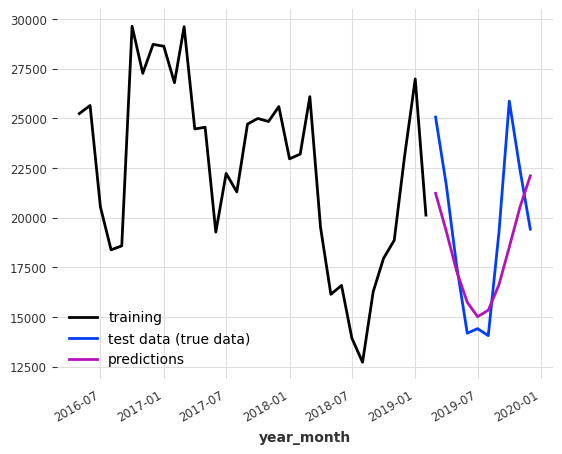

In [ ]:

#train the model and generate predictions
temp = TBATS()
temp.fit(train)
TBATS_preds = temp.predict(len(test))


train.plot(label="training")
test.plot(label="test data (true data)")
TBATS_preds.plot(label = "predictions")

In [ ]:
!pip install prophet

In [ ]:
from prophet import Prophet

In [ ]:
import pandas as pd

df = pd.read_csv("/content/1513_new.csv")

# fitting the Prophet model
m = Prophet()
m.fit(df.rename(columns={"year_month": "ds", "total_paid": "y"}))


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9znmzd4d/xjs9fidw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9znmzd4d/itgvnlmp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43418', 'data', 'file=/tmp/tmp9znmzd4d/xjs9fidw.json', 'init=/tmp/tmp9znmzd4d/itgvnlmp.json', 'output', 'file=/tmp/tmp9znmzd4d/prophet_modelxt470v69/prophet_model-20240213130945.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
13:09:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
13:09:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
future = m.make_future_dataframe(periods=10, freq="w")
future.tail()

,ds
50,2020-01-12
51,2020-01-19
52,2020-01-26
53,2020-02-02
54,2020-02-09


In [ ]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
50,2020-01-12,-12709.786014,-15374.247853,-9926.980357
51,2020-01-19,-21087.651602,-23869.356544,-18492.148312
52,2020-01-26,-8770.001923,-11543.636061,-6008.820129
53,2020-02-02,21471.709396,18911.625353,24112.762008
54,2020-02-09,50376.900722,47811.352282,53013.559757


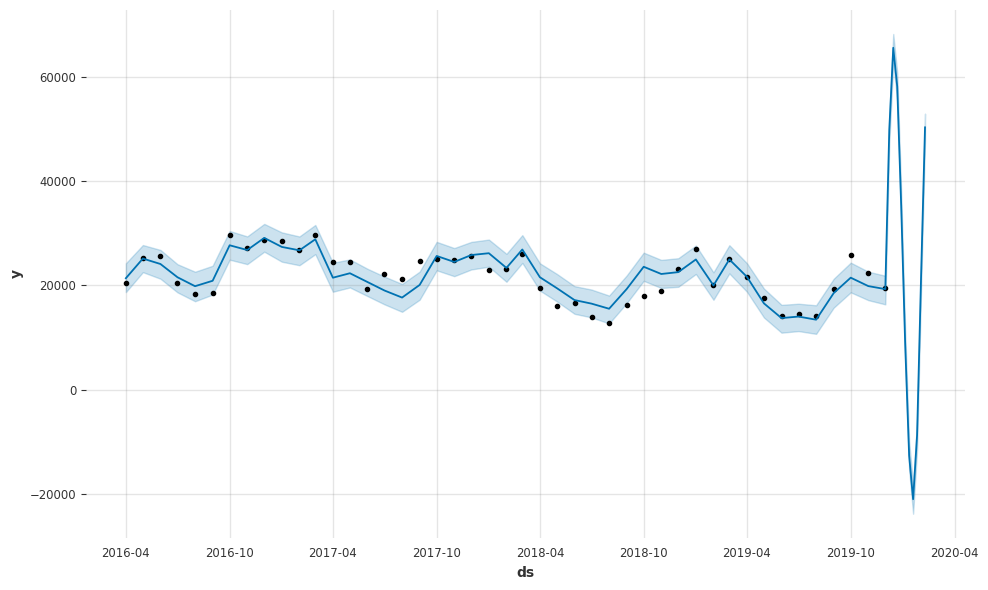

In [ ]:
fig1 = m.plot(forecast)

In [ ]:
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2016-04-01,25841.371331,18713.853036,24249.582927,25841.371331,25841.371331,-4457.920880,-4457.920880,-4457.920880,-4457.920880,-4457.920880,-4457.920880,0.0,0.0,0.0,21383.450450
1,2016-05-01,25663.444169,22553.484244,27764.779563,25663.444169,25663.444169,-500.174057,-500.174057,-500.174057,-500.174057,-500.174057,-500.174057,0.0,0.0,0.0,25163.270112
2,2016-06-01,25479.586102,21286.864630,26824.202071,25479.586102,25479.586102,-1361.831380,-1361.831380,-1361.831380,-1361.831380,-1361.831380,-1361.831380,0.0,0.0,0.0,24117.754722
3,2016-07-01,25301.658940,18667.919938,24080.144732,25301.658940,25301.658940,-3727.588699,-3727.588699,-3727.588699,-3727.588699,-3727.588699,-3727.588699,0.0,0.0,0.0,21574.070241
4,2016-08-01,25117.800873,16960.896878,22633.349910,25117.800873,25117.800873,-5264.518123,-5264.518123,-5264.518123,-5264.518123,-5264.518123,-5264.518123,0.0,0.0,0.0,19853.282750


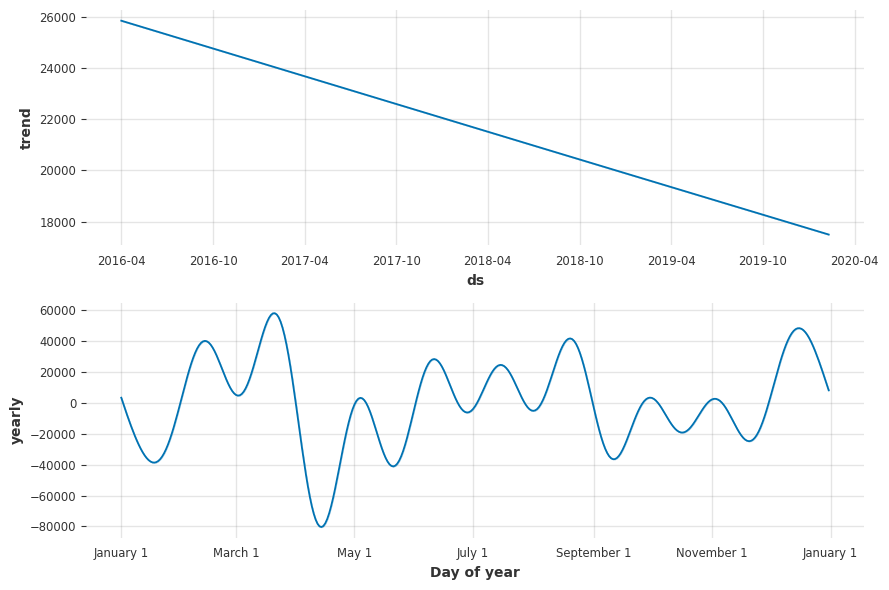

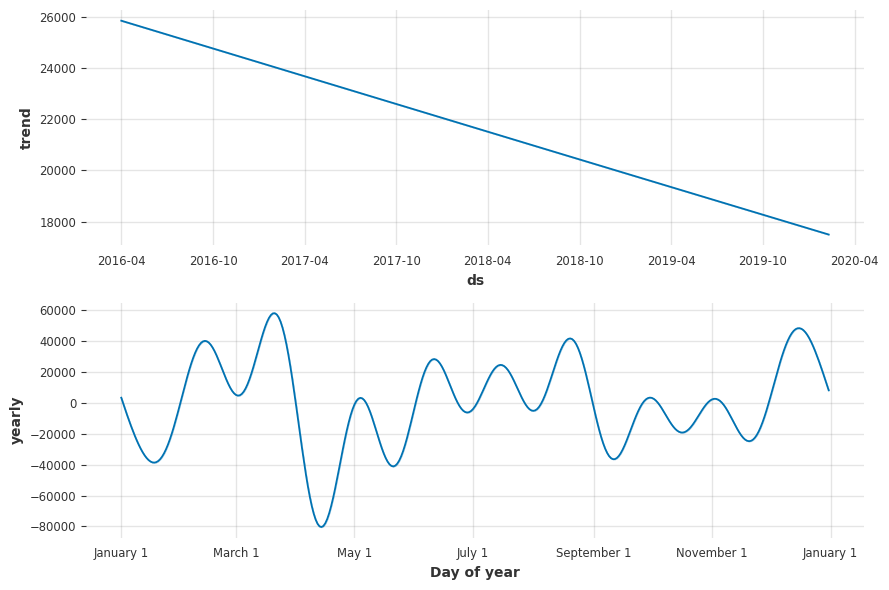

In [ ]:
m.plot_components(forecast)

In [ ]:
from prophet.plot import plot_plotly, plot_components_plotly

plot_plotly(m, forecast)